In [ ]:
!pip install wikipedia-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13477 sha256=c692058aceb7a2d562316293cded6fa6f29e8cb3d9ff299e0865f84f430a134f
  Stored in directory: /root/.cache/pip/wheels/d3/24/56/58ba93cf78be162451144e7a9889603f437976ef1ae7013d04
Successfully built wikipedia-api


In [ ]:

import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl,
                        'categories': list(page.categories.keys())}
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(topic_name))
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None     
    progress.close() if verbose else None
    
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(namespaces, na=True))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Wikipedia pages scraped:', len(sources))
    
    return sources


In [ ]:
wiki_data = wiki_scrape('Systems design ')


Links Scraped: 100%|██████████| 411/411 [00:18<00:00, 22.36/s] 

Wikipedia pages scraped: 166


In [ ]:
%mkdir temp

%cd temp

!git clone https://github.com/huggingface/neuralcoref.git
!pip install -U spacy
!python -m spacy download en

%cd neuralcoref

!pip install -r requirements.txt
!pip install -e .

In [ ]:
text = "A ratio showing how often people who see your ad or free product listing end up clicking it. \
 Clickthrough rate (CTR) can be used to gauge how well your keywords and ads, and free listings, are performing.\
 CTR is the number of clicks that your ad receives divided by the number of times your ad is shown: clicks ÷ impressions = CTR. \
 For example, if you had 5 clicks and 100 impressions, then your CTR would be 5%.Each of your ads, listings, and keywords have \
 their own CTRs that you can see listed in your account.A high CTR is a good indication that users find your ads and listings \
 helpful and relevant. CTR also contributes to your keyword's expected CTR, which is a component of Ad Rank. Note that a good CTR \
 is relative to what you're advertising and on which networks.You can use CTR to gauge which ads, listings, and keywords are successful \
 for you and which need to be improved. The more your keywords, ads, and listings relate to each other and to your business, the more likely \
 a user is to click on your ad or listing after searching on your keyword phrase."

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import pandas as pd
import re
import spacy
import en_core_web_lg
import neuralcoref



nlp = en_core_web_lg.load()

# nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)

def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

In [ ]:
pairs = get_entity_pairs(wiki_data.loc[5,'text'])
# pairs = get_entity_pairs('text')
# text

Entity pairs extracted: 40


In [ ]:
wiki_data.head(50)

,page,text,link,categories,topic
0,Systems design,Systems design is the process of defining the ...,https://en.wikipedia.org/wiki/Systems_design,"[All articles needing additional references, A...",Systems design
1,.design,.design is a top-level domain name. It was pro...,https://en.wikipedia.org/wiki/.design,"[All Wikipedia articles in need of updating, C...",Systems design
2,Activity-centered design,Activity-centered design (ACD) is an extension...,https://en.wikipedia.org/wiki/Activity-centere...,[All Wikipedia articles written in American En...,Systems design
3,ACM Transactions on Computer Systems,ACM Transactions on Computer Systems is a quar...,https://en.wikipedia.org/wiki/ACM_Transactions...,"[All articles needing additional references, A...",Systems design
4,Adaptive web design,Adaptive web design (AWD) promotes the creatio...,https://en.wikipedia.org/wiki/Adaptive_web_design,"[Adaptive web design, All Wikipedia articles i...",Systems design
5,Advertising,Advertising is a marketing communication that ...,https://en.wikipedia.org/wiki/Advertising,"[Advertising, All accuracy disputes, All artic...",Systems design
6,Aerospace engineering,Aerospace engineering is the primary field of ...,https://en.wikipedia.org/wiki/Aerospace_engine...,"[Aerospace engineering, Aircraft maintenance, ...",Systems design
7,Affective design,The notion of affective design emerged from th...,https://en.wikipedia.org/wiki/Affective_design,"[All stub articles, Computer science stubs, Cu...",Systems design
8,Agile software development,"In software development, agile (sometimes writ...",https://en.wikipedia.org/wiki/Agile_software_d...,"[Agile software development, All articles with...",Systems design
9,Aesthetics,"Aesthetics, or esthetics (), is a branch of ph...",https://en.wikipedia.org/wiki/Aesthetics,"[1730s neologisms, Aesthetics, All Wikipedia a...",Systems design


In [ ]:
pairs

,subject,relation,object,subject_type,object_type
0,Non - profit organizations,use,free modes,NOUN_CHUNK,NOUN_CHUNK
1,Modern advertising,originated with,Madison Avenue advertising,NOUN_CHUNK,NOUN_CHUNK
2,Advertisement,takes in,form,NOUN_CHUNK,NOUN_CHUNK
3,Volney B. Palmer,established,roots,PERSON,NOUN_CHUNK
4,American government,promoted,advertising,NOUN_CHUNK,NOUN_CHUNK
5,Herbert Hoover,delivered,address,PERSON,NOUN_CHUNK
6,The late 1980s,saw,introduction,DATE,NOUN_CHUNK
7,classification,include,display advertising,NOUN_CHUNK,NOUN_CHUNK
8,Commercial advertising media,include,wall paintings,NOUN_CHUNK,NOUN_CHUNK
9,50%,known,advertisements,PERCENT,NOUN_CHUNK


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

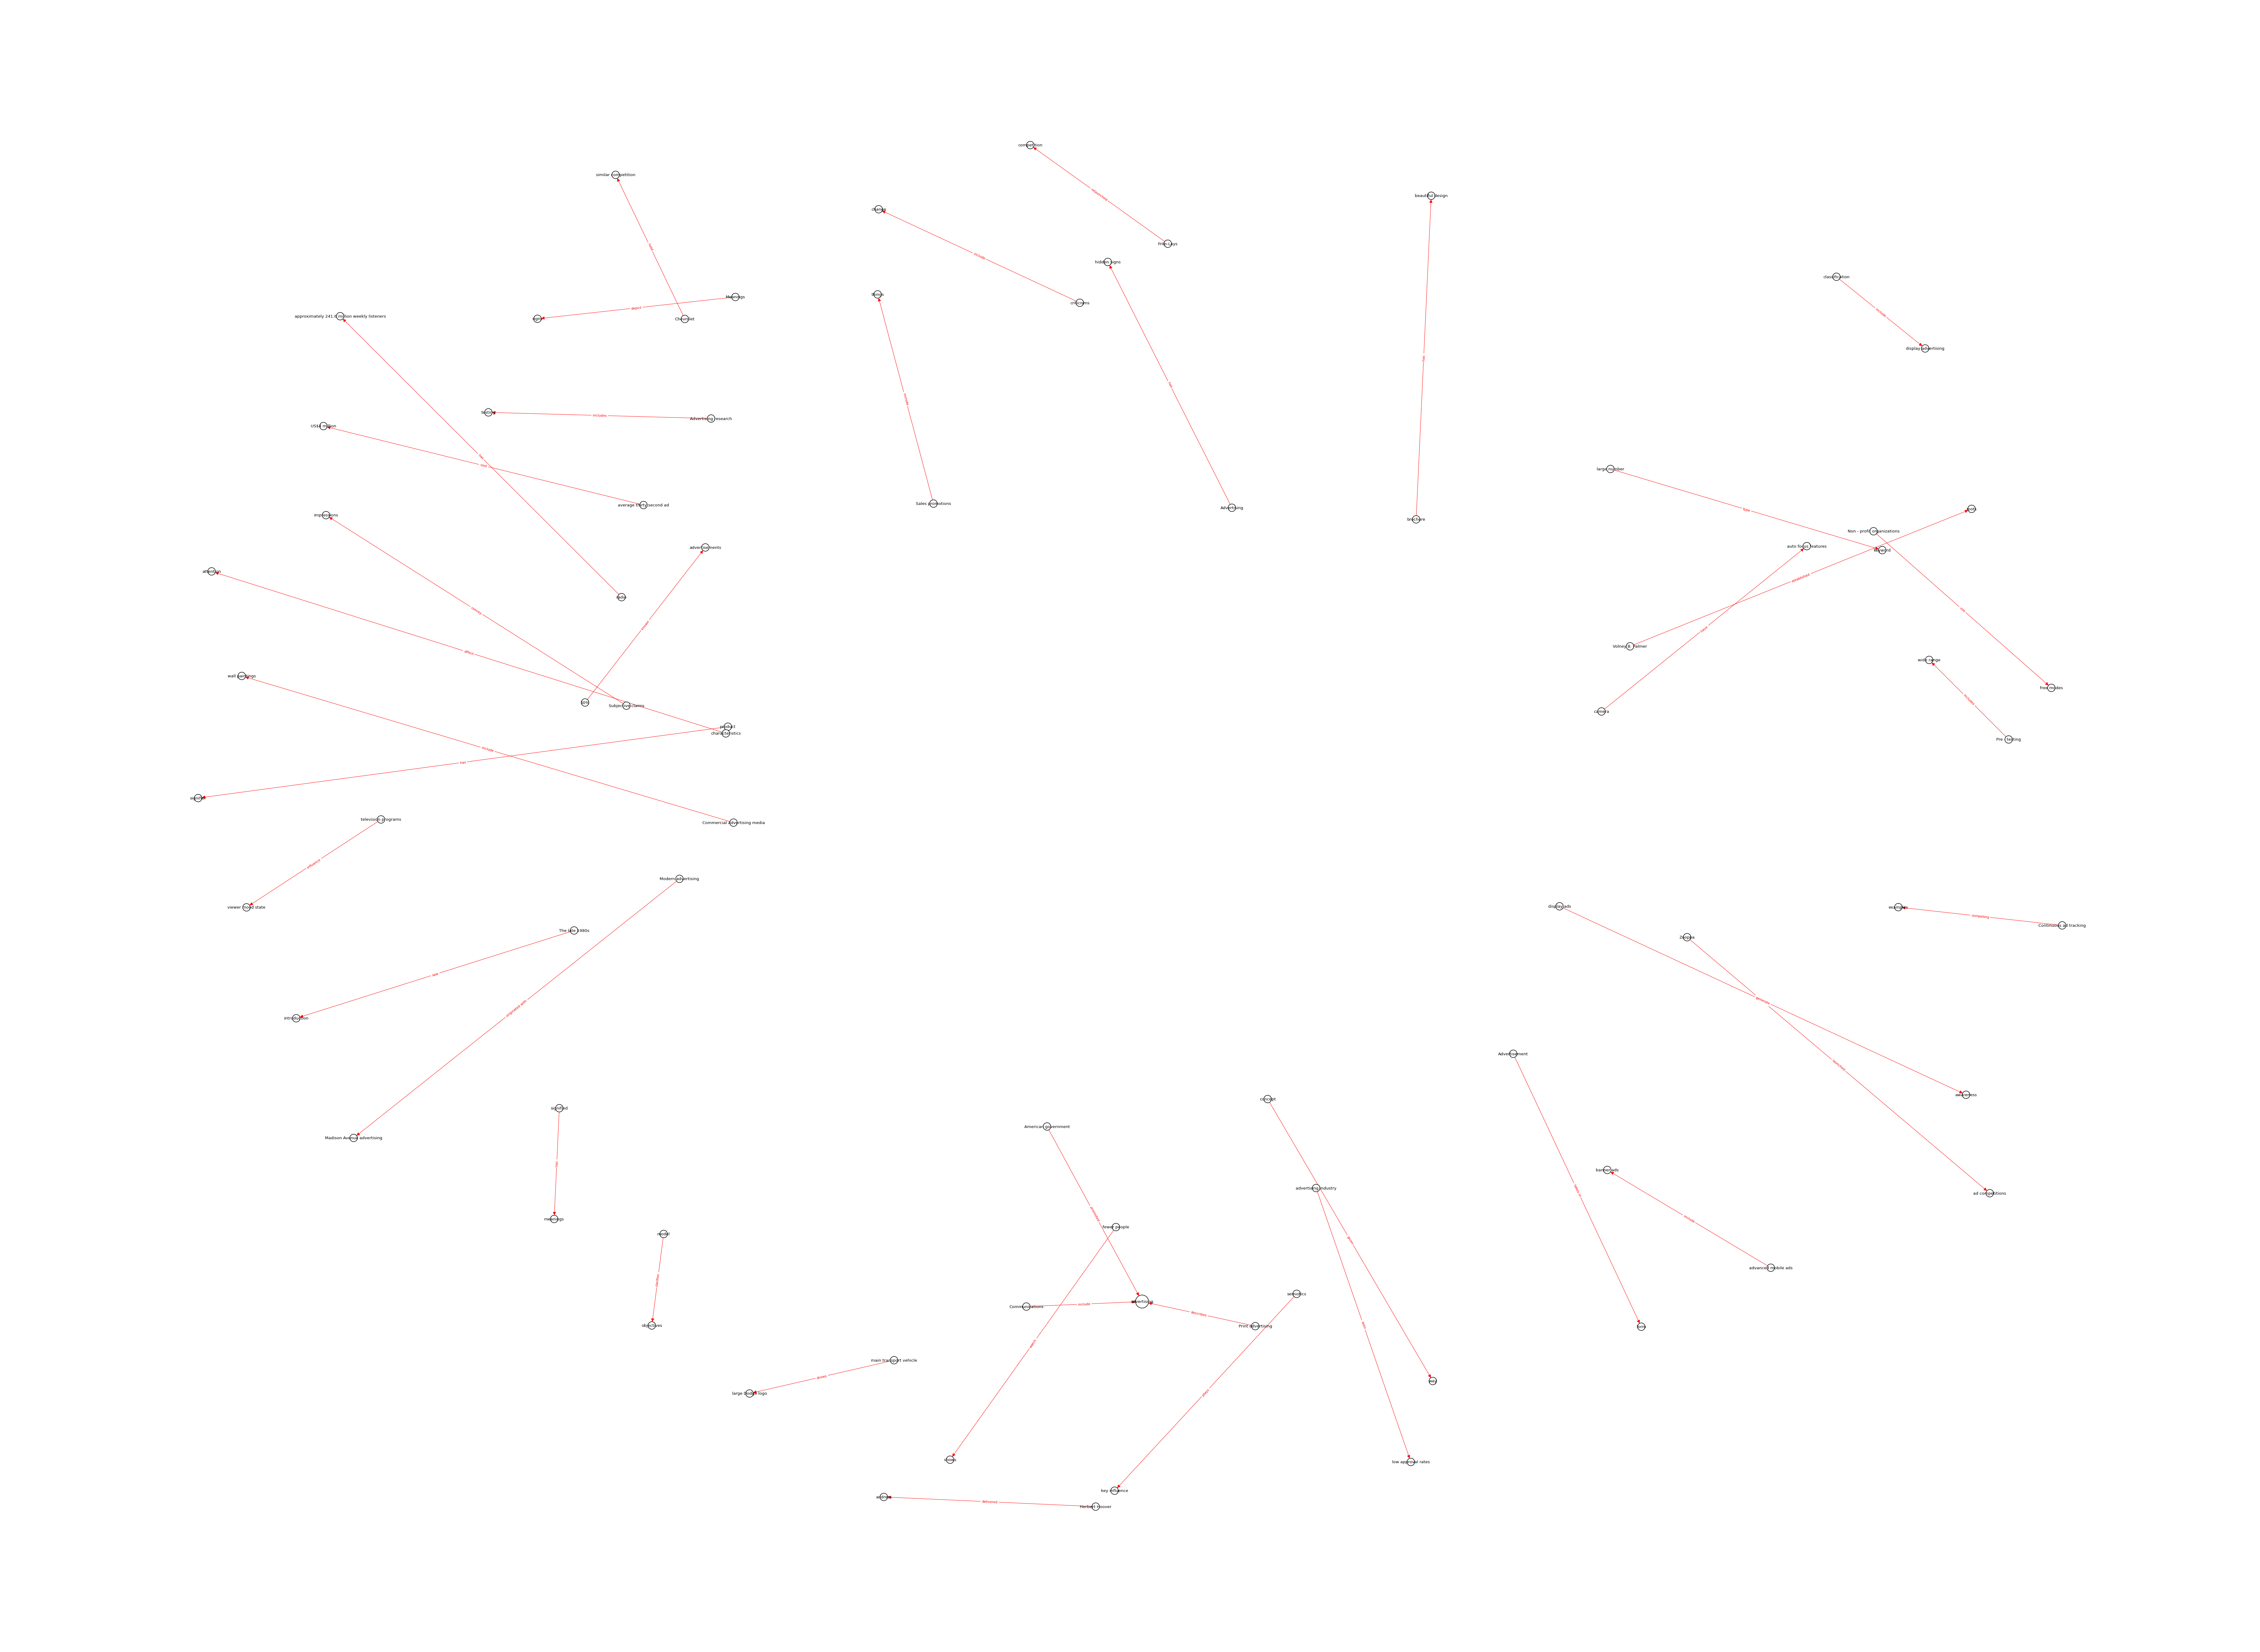

In [ ]:
draw_kg(pairs)

In [ ]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

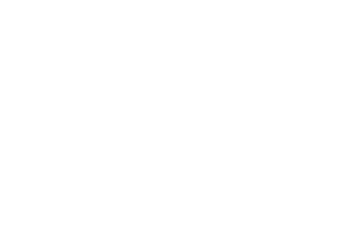

In [ ]:
filter_graph(pairs,'roots')

In [ ]:
pairs.head()

,subject,relation,object,subject_type,object_type
0,Non - profit organizations,use,free modes,NOUN_CHUNK,NOUN_CHUNK
1,Modern advertising,originated with,Madison Avenue advertising,NOUN_CHUNK,NOUN_CHUNK
2,Advertisement,takes in,form,NOUN_CHUNK,NOUN_CHUNK
3,Volney B. Palmer,established,roots,PERSON,NOUN_CHUNK
4,American government,promoted,advertising,NOUN_CHUNK,NOUN_CHUNK
